Let's evaluate our weather api agent!

In [ ]:
!pip install openinference-instrumentation-langchain

In [1]:
import phoenix as px
import os
from phoenix.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider

In [ ]:
# px.launch_app() 


If activated from notebook using launch_app, the server also goes off when notebook is stopped, if use_temp_dir = False is not set in launch_app. So, better to start using `phoenix serve` from terminal and let it run. When you turn back the terminal on, it shows the data stored in previous sessions as well. Terminal automatically stores the projects and datasets

In [2]:
import os
from dotenv import load_dotenv, find_dotenv

def load_env():
    _ = load_dotenv(find_dotenv(), override=True)
def get_openai_api_key():
    load_env()
    openai_api_key = os.getenv("OPENAI_API_KEY")
    return openai_api_key

In [3]:
def get_phoenix_endpoint():
    load_env()
    phoenix_endpoint = os.getenv("PHOENIX_COLLECTOR_ENDPOINT")
    return phoenix_endpoint

In [4]:
MODEL = "gpt-4o-mini"

# Tracing With Langchain Instrumentor

In [6]:
PROJECT_NAME = 'Weather_Agent_Custom'

In [ ]:
tracer_provider = register(
    project_name=PROJECT_NAME,
    endpoint= get_phoenix_endpoint() + "v1/traces",
    auto_instrument=True
)

For langchain, just install the required OI dependency of langchain for phoenix and everything will work fine! For the custom chains, we need to use OpenAI Instrumentor. Check the other section. With langchain, the auto_instrument option works really well in Phoenix. Trust me! I tried both versions 

I added the below cell after experimenting quite a few times with different configurations. Reason is at [Uninstrumenting OpenAI](#uninstrument_reason)

In [8]:
OpenAIInstrumentor().uninstrument() 

In [9]:
tracer = tracer_provider.get_tracer(__name__)

## Required Functions

In [21]:
from langchain_core.outputs import LLMResult
from langchain_core.tools import tool
import requests
import os
from dotenv import load_dotenv
load_dotenv()
OPEN_WEATHER_API_KEY = os.getenv("OPEN_WEATHER_API_KEY")
import os
from langchain.agents import create_tool_calling_agent, AgentExecutor, create_structured_chat_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage, ChatMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain.callbacks.base import BaseCallbackHandler
# from langchain_community.callbacks.streamlit import StreamlitCallbackHandler
from langchain_community.chat_message_histories import SQLChatMessageHistory
from openai import AuthenticationError
from langchain.memory import ConversationBufferMemory
import pandas as pd
# from streamlit_lottie import st_lottie

In [11]:
def get_response(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    else:
        print("Error:", response.status_code)
    return data

In [12]:
df = pd.read_csv('country_code.csv', header = 0)
df['name'] = df['name'].str.upper()

## Tools of My Weather API Agent

In [101]:
@tool# @tracer.tool() # if tool needs to be in separate span, we can include this decorator but for Langchain, it automatically does that, so it is not required
def get_geo_data_from_city_or_zip(zip_code=None, country_name=None, city_name=None,):
    '''Get Geographical data with latitude and longitude using zip code and country name or city name and country name combinations. When zip code is passed, country name must be present.'''
    try:
        country_code = None
        if country_name is not None:
            country_code = (df[(df['name'] == country_name.upper()) | (df['alpha-2'] == country_name.upper()) | (df['alpha-3'] == country_name.upper())]['alpha-2']).iloc[0]
        if city_name is None and zip_code is None:
            return "Need city name or zip code"
        if zip_code is not None:
            # url = f'http://api.openweathermap.org/geo/1.0/zip?zip={zip_code},{country_code}&appid={api_key.OPEN_WEATHER_API_KEY}'
            url = f'http://api.openweathermap.org/geo/1.0/zip?zip={zip_code},{country_code}&appid={OPEN_WEATHER_API_KEY}'
            geo_data = get_response(url)
        elif city_name is not None:
            url = f'http://api.openweathermap.org/geo/1.0/direct?q={city_name},{country_code}&limit=1&appid={OPEN_WEATHER_API_KEY}'
            url = f'http://api.openweathermap.org/geo/1.0/direct?q={city_name},{country_code}&limit=1&appid={OPEN_WEATHER_API_KEY}'
            geo_data = get_response(url)[0]
        else:
            return "Wrong"
        return geo_data
    except:
        return "Something is wrong in get geo data tool. There is a chance that zipcode is given without country name. Get that from the user."


@tool# @tracer.tool()
def get_weather(geo_data, is_forecast, local_requested_timestamp):
    '''Getting current weather or forecast for the upcoming 5 days (not more than that) at a specified geo location. Geo data must be received from get_geo_data_from_city_or_zip before calling this tool. If it's a forecast, we MUST need the local_requested_timestamp generated from get_local_datetime tool.'''

    try:
        if not is_forecast:
            # url = f'https://api.openweathermap.org/data/2.5/weather?lat={geo_data['lat']}&lon={geo_data['lon']}&appid={api_key.OPEN_WEATHER_API_KEY}&units=imperial'
            url = f'https://api.openweathermap.org/data/2.5/weather?lat={geo_data['lat']}&lon={geo_data['lon']}&appid={OPEN_WEATHER_API_KEY}&units=imperial'
            data = get_response(url)
            return data
        else:
            # url = f'https://api.openweathermap.org/data/2.5/forecast?lat={geo_data['lat']}&lon={geo_data['lon']}&appid={api_key.OPEN_WEATHER_API_KEY}&units=imperial'
            url = f'https://api.openweathermap.org/data/2.5/forecast?lat={geo_data['lat']}&lon={geo_data['lon']}&appid={OPEN_WEATHER_API_KEY}&units=imperial'
            data = get_response(url)
            only_date_json = {}
            value = data["list"][0]["dt"]
            for i in data["list"]:
                if abs(i["dt"] - local_requested_timestamp) > value:
                    break
                else:
                    value = abs(i["dt"] - local_requested_timestamp)
                    only_date_json = i
                    # print(value)
            
            return only_date_json
    except:
        return "Tool has been called in the wrong order. Call get_geo_data_from_city_or_zip with relevant parameters first."

@tool# @tracer.tool()
def get_local_datetime(geo_data, days = 0, hour = 10):
    '''If a future weather forecast is queried, this tool must be called and the returned value MUST be used in get_weather function's local_requested_timestamp variable.'''
    from datetime import datetime, timedelta
    from timezonefinder import TimezoneFinder
    import pytz
    obj = TimezoneFinder()
    latitude =  geo_data["lat"]
    longitude = geo_data["lon"]
    local_timezone= obj.timezone_at(lng=longitude, lat=latitude)
    local_requested_datetime = (datetime.now(pytz.timezone(local_timezone)) + timedelta(days = days))
    if days != 0:
        local_requested_datetime = local_requested_datetime.replace(hour=hour, minute=0, second=0)
    return local_requested_datetime.timestamp()


## Agent Call

In [15]:
msgs.clear()

NameError: name 'msgs' is not defined

In [14]:
openai_api_key = get_openai_api_key()
username = 'test'

def start_main_span(user_query):
    if username and openai_api_key.startswith('sk-'):
        db_path = 'local_sqlite_db.db'
        msgs = SQLChatMessageHistory(
            session_id=username,
            connection_string="sqlite:///" + db_path  # This is the SQLite connection string
        )

        if len(msgs.messages) == 0:
            msgs.clear()
            msgs.add_ai_message("How can I help you?")

        avatars = {"human": "user", "ai": "assistant"}
        # for msg in msgs.messages:
        #     st.chat_message(avatars[msg.type]).write(msg.content)

        #Below span creation codes are just used when you create your own agent, may be directly with openAI. With langchain, everything is created automatically
        # with tracer.start_as_current_span(
        #         "AgentRun", openinference_span_kind="agent",
        #     ) as span:
            # span.set_attribute('history', str(msgs))
        tools = [get_geo_data_from_city_or_zip, get_local_datetime,get_weather]
        # llm = ChatOpenAI(model="gpt-3.5-turbo-0125", streaming=True)
        llm = ChatOpenAI(model=MODEL, streaming=True)
        llm_with_tools = llm.bind_tools(tools)

        #prompt should contain ("placeholder", "{agent_scratchpad}"), so I'm rewriting the prompt here
        examples = [
            HumanMessage(
                "Get weather at Rocklin for tomorrow at 6PM", name="example_user"
            ),
            AIMessage(
                "",
                name = "example_assistant",
                tool_calls = [
                    {"name": "get_geo_data_from_city_or_zip", "args": {"city_name": "Rocklin"}, "id": "3"}
                ]
            ),
            ToolMessage('''{
                "name": "Rocklin",
                "lat": 38.7907339,
                "lon": -121.2357828,
                "country": "US",
                "state": "California"
            }''', tool_call_id="3"),
            AIMessage(
                "",
                name = "example_assistant",
                tool_calls = [
                    {"name": "get_local_datetime", "args": {"geo_data": {'name': 'Rocklin','lat': 38.7907339,'lon': -121.2357828,'country': 'US','state': 'California'}, "days" : 1, "hour" : 18}, "id": "4"}
                ]
            ),
            ToolMessage(1714352798.281548, tool_call_id="4"),
            AIMessage(
                "",
                name="example_assistant",
                tool_calls=[
                    {"name": "get_weather", "args": {"geo_data":{'name': 'Rocklin','lat': 38.7907339,'lon': -121.2357828,'country': 'US','state': 'California'}, "is_forecast" : 1, "local_requested_timestamp" :1714352798.281548}, "id": "5"}
                ],
            ),
            ToolMessage('''{'dt': 1714327200,
                'main': {'temp': 65.95,
                'feels_like': 64.63,
                'temp_min': 65.95,
                'temp_max': 65.95,
                'pressure': 1019,
                'sea_level': 1019,
                'grnd_level': 1009,
                'humidity': 51,
                'temp_kf': 0},
                'weather': [{'id': 801,
                'main': 'Clouds',
                'description': 'few clouds',
                'icon': '02d'}],
                'clouds': {'all': 11},
                'wind': {'speed': 5.73, 'deg': 294, 'gust': 6.26},
                'visibility': 10000,
                'pop': 0,
                'sys': {'pod': 'd'},
                'dt_txt': '2024-04-28 18:00:00'}''', tool_call_id = "5"),
            AIMessage(
                "The temperature at Rocklin tommorow around 6 PM is 65.95 F with few clouds .",
                name="example_assistant",
            ),
        ]

        system = """You are bad at predicting weather but an expert at using tools those give you a current weather or a forecast report. DO NOT ANSWER YOURSELF, ALWAYS USE TOOLS. If the user queries zipcode without a country name, ask for the country name or code. If the query is about a forecast, take is_forecast as 1 and always use the generated timestamp from get_local_datetime tool in get_weather function.
        Use past tool usage order as an example on how to correctly use the tools. If the query asks for weather information for a date which is beyond 5 days from today, only then tell them that you only have information for the next five days, otherwise don't tell."""

        few_shot_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                *examples,
                MessagesPlaceholder("chat_history", optional=True),
                ("human", "{query}"),
                ("placeholder", "{agent_scratchpad}")
            ]
        )

        agent = create_tool_calling_agent(llm_with_tools, tools, few_shot_prompt)
        memory = ConversationBufferMemory(memory_key="chat_history",chat_memory=msgs, return_messages=True)
        agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False, memory=memory)

        # span.set_input(value=user_query)
        response = agent_executor.invoke(
                {"query" : user_query},  
            )

        # span.set_output(value=response['output'])
        # span.set_status(StatusCode.OK)
        return response

### Uninstrumenting Reasoning

When I used without custom span creation, the AgentExecutor was logged in a single trace but the LLM completions for each tool call is also logged separately outside of AgentExecutor since Langchain calls LLM's in between and Phoenix has a configuration to log them separately. This contradicts and storing 4 traces for a single run is not feasible. So, I'm adding custom span creation as an additional layer to actually have one trace for one run

<a id='uninstrument_reason'></a>
Later, I came to know that this custom tracing is not needed if we uninstrument the OpenAI module. I did that as well in the above part, because even after enclosing everything in a single trace, I got the LLM model calling duplicates which could be problematic when we evaluate. When I uninstrumented the OpenAI instrumetor, I got only single trace of LangChain's Agent Executor as below.

In [53]:
# OpenAIInstrumentor().uninstrument()

In [16]:
user_query = "What kind of clothing do I need? I'm in Los Angeles, California"
response = start_main_span(user_query)
print(user_query)
print(response['output'])

/var/folders/r0/9515969s651bj983pxgsbgyc0000gn/T/ipykernel_21492/273170784.py:2: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  response = start_main_span(user_query)
/var/folders/r0/9515969s651bj983pxgsbgyc0000gn/T/ipykernel_21492/3860620586.py:104: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history",chat_memory=msgs, return_messages=True)


What kind of clothing do I need? I'm in Los Angeles, California
Currently, in Los Angeles, the temperature is about 48.4°F with broken clouds. It feels a bit cooler at 45.3°F. Given this weather, you should consider wearing layers, including a warm jacket or sweater, and possibly a scarf to stay comfortable.


<!-- <div>
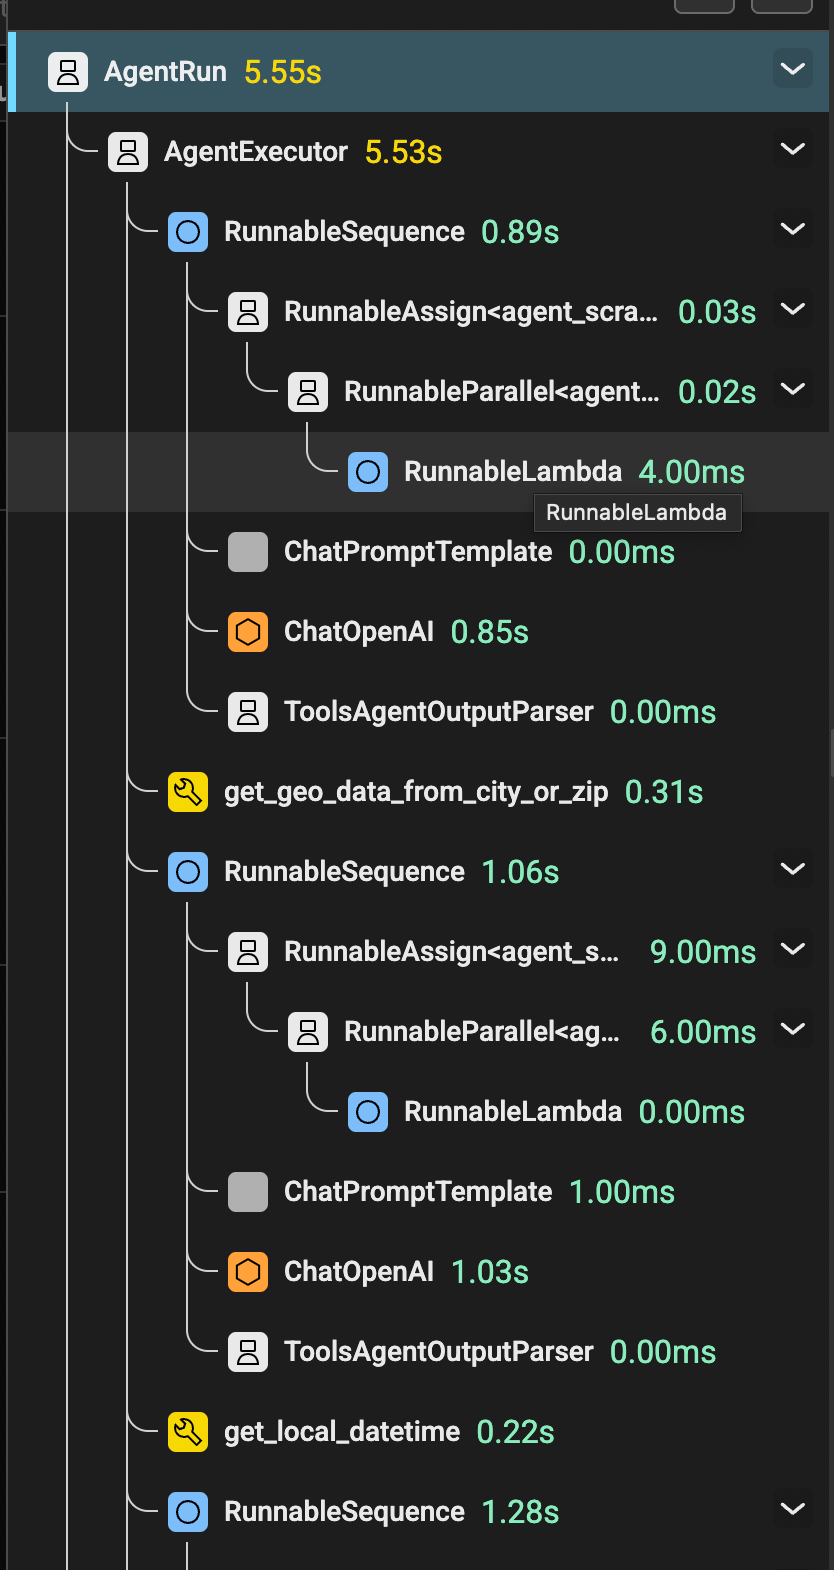
</div> -->
<img src="images/trace_screenshot.png" width="250" height="500"> 


# Router and Tool Evaluations

In [5]:
import phoenix as px
import os
import json
from tqdm import tqdm
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, 
    llm_classify,
    OpenAIModel
)
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery
from openinference.instrumentation import suppress_tracing

import nest_asyncio
nest_asyncio.apply()

## Running Agent with a Set of Testing Questions

In [18]:
agent_questions = [
    "Is it cloudy or rainy in Phoenix, Arizona tomorrow?",
    "What's the current temperature in London and will it rain today?",
    "Is it going to be windy in San Francisco tomorrow afternoon?",
    "How much snow is expected in Denver this weekend?",
    "What's the humidity level in Tokyo right now, and is there a chance of thunderstorms?",
    "What are the expected high and low temperatures for the next five days in Miami?",
    "Should I wear a light jacket or a heavy coat if I'm going to the park tomorrow afternoon in Chicago?",
    "I'm planning a picnic in San Diego on Saturday. Will I need to bring sunscreen and a hat?",
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        print(question)
        ret = start_main_span(user_query=question)
        print(ret['output'])
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

Processing questions:   0%|          | 0/8 [00:00<?, ?it/s]

Is it cloudy or rainy in Phoenix, Arizona tomorrow?


Processing questions:  12%|█▎        | 1/8 [00:06<00:45,  6.44s/it]

Tomorrow in Phoenix, Arizona, it will be a clear sky with no clouds and no chance of rain. You can expect a pleasant day for any outdoor activities!
What's the current temperature in London and will it rain today?


Processing questions:  25%|██▌       | 2/8 [00:12<00:36,  6.05s/it]

Could you please provide the country name or code for London?
Is it going to be windy in San Francisco tomorrow afternoon?


Processing questions:  38%|███▊      | 3/8 [00:17<00:29,  5.92s/it]

Tomorrow afternoon in San Francisco, the temperature will be around 54.37°F with scattered clouds and wind speeds of about 8.99 mph. It doesn't appear to be particularly windy, so you should be comfortable without worrying too much about strong winds.
How much snow is expected in Denver this weekend?


Processing questions:  50%|█████     | 4/8 [00:18<00:15,  3.98s/it]

I can only provide weather information for the next five days. Would you like to know the weather forecast for Denver within that timeframe?
What's the humidity level in Tokyo right now, and is there a chance of thunderstorms?


Processing questions:  62%|██████▎   | 5/8 [00:19<00:08,  2.89s/it]

Could you please provide the country name or code for Tokyo?
What are the expected high and low temperatures for the next five days in Miami?


Processing questions:  75%|███████▌  | 6/8 [00:44<00:20, 10.11s/it]

Here are the expected high and low temperatures for the next five days in Miami:

- **Day 1**: High of 78.13°F, Low of 73.56°F (Light rain expected)
- **Day 2**: High of 75.65°F, Low of 75.65°F (Light rain expected)
- **Day 3**: High of 68.40°F, Low of 68.40°F (Clear sky)
- **Day 4**: High of 72.52°F, Low of 72.52°F (Clear sky)
- **Day 5**: High of 72.52°F, Low of 72.52°F (Clear sky)

Let me know if you need any more information!
Should I wear a light jacket or a heavy coat if I'm going to the park tomorrow afternoon in Chicago?


Processing questions:  88%|████████▊ | 7/8 [00:50<00:08,  8.77s/it]

Tomorrow afternoon in Chicago, the temperature will be around 40.69°F with overcast clouds and a wind chill making it feel like 34.77°F. Given these conditions, it's advisable to wear a heavy coat rather than a light jacket to stay warm.
I'm planning a picnic in San Diego on Saturday. Will I need to bring sunscreen and a hat?


Processing questions: 100%|██████████| 8/8 [00:56<00:00,  7.04s/it]

On Saturday in San Diego, the temperature is expected to be around 68.16°F with a few clouds. Given the pleasant weather and moderate UV exposure, it would be a good idea to bring sunscreen and a hat for sun protection during your picnic. Enjoy your time!


## Router Evals using LLM-as-a-Judge

In [6]:
print(TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

In [25]:
# Getting langchain's tools' name, description (docstring) and args to frame the tool_definitions 
tool_definitions = []
for i in [get_geo_data_from_city_or_zip, get_local_datetime, get_weather]:
    tool_definitions.append({"type": "function", "function": {'name': i.name, 'description' : i.description, 'parameters': i.args}})

In [ ]:
tool_definitions

In [7]:
PROJECT_NAME = 'Weather_Agent_Custom'

In [44]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    question="llm.input_messages",
    output_messages="llm.output_messages",
    tool_call = "llm.function_call"
)


# The Phoenix Client can take this query and return the dataframe.
tool_calls_df_2 = px.Client().query_spans(query, 
                                        project_name=PROJECT_NAME, 
                                        timeout=None)
# tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df_2.head()

,question,output_messages,tool_call
context.span_id,,,
5aa2616c6c994abb,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,None
1b471c07ecf59a97,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,None
d5e7e8d7dbee95de,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,None
e030c552b4894046,[{'message': {'content': 'You are bad at predi...,"[{'message': {'content': 'Currently, in Los An...",None
c3006cc0892b882a,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,None


In [46]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    question = "llm.input_messages", #when using "input.value", the template was not able to take the proper question, so I just referred doc to use this
    output_messages="llm.output_messages" #"llm.function_call" gave none so, extracting from output_messages
)


# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, 
                                        project_name=PROJECT_NAME, 
                                        timeout=None)
# tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df.head()

,question,output_messages
context.span_id,,
5aa2616c6c994abb,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...
1b471c07ecf59a97,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...
d5e7e8d7dbee95de,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...
e030c552b4894046,[{'message': {'content': 'You are bad at predi...,"[{'message': {'content': 'Currently, in Los An..."
c3006cc0892b882a,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...


In [35]:
# tool_calls_df.iloc[0,1].keys()

dict_keys(['model_name', 'output_messages', 'invocation_parameters', 'input_messages'])

In [47]:
def filter_tool_calls(x):
    try:
        return x[0]['message']['tool_calls']
    except:
        None

tool_calls_df['tool_calls'] = tool_calls_df['output_messages'].apply(filter_tool_calls)

In [48]:
tool_calls_df.head()

,question,output_messages,tool_calls
context.span_id,,,
5aa2616c6c994abb,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,"[{'tool_call': {'function': {'arguments': '{""c..."
1b471c07ecf59a97,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,"[{'tool_call': {'function': {'arguments': '{""g..."
d5e7e8d7dbee95de,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,"[{'tool_call': {'function': {'arguments': '{""g..."
e030c552b4894046,[{'message': {'content': 'You are bad at predi...,"[{'message': {'content': 'Currently, in Los An...",None
c3006cc0892b882a,[{'message': {'content': 'You are bad at predi...,[{'message': {'tool_calls': [{'tool_call': {'f...,"[{'tool_call': {'function': {'arguments': '{""c..."


In [49]:
len(tool_calls_df[tool_calls_df['tool_calls'].isnull()])

9

In [50]:
#remove None entries
tool_calls_df = tool_calls_df[~tool_calls_df['tool_calls'].isnull()]
tool_calls_df.shape

(27, 3)

In [51]:
tool_calls_df.iloc[0,0]

[{'message': {'content': "You are bad at predicting weather but an expert at using tools those give you a current weather or a forecast report. DO NOT ANSWER YOURSELF, ALWAYS USE TOOLS. If the user queries zipcode without a country name, ask for the country name or code. If the query is about a forecast, take is_forecast as 1 and always use the generated timestamp from get_local_datetime tool in get_weather function.\n        Use past tool usage order as an example on how to correctly use the tools. If the query asks for weather information for a date which is beyond 5 days from today, only then tell them that you only have information for the next five days, otherwise don't tell.",
   'role': 'system'}},
 {'message': {'content': 'Get weather at Rocklin for tomorrow at 6PM',
   'name': 'example_user',
   'role': 'user'}},
 {'message': {'name': 'example_assistant', 'role': 'assistant'}},
 {'message': {'content': '{\n                "name": "Rocklin",\n                "lat": 38.7907339,\

In [52]:
tool_calls_df.iloc[0,2]

[{'tool_call': {'function': {'arguments': '{"city_name":"Los Angeles","country_name":"US"}',
    'name': 'get_geo_data_from_city_or_zip'}}}]

In [53]:
#template has columns as question and tool_call
tool_calls_df = tool_calls_df.rename(columns = {'tool_calls' : 'tool_call'})[['question', 'tool_call']]

In [165]:
tool_calls_df.head()

,question,tool_call
context.span_id,,
5aa2616c6c994abb,[{'message': {'content': 'You are bad at predi...,"{'function': {'arguments': '{""city_name"":""Los ..."
1b471c07ecf59a97,[{'message': {'content': 'You are bad at predi...,"{'function': {'arguments': '{""geo_data"":{""name..."
d5e7e8d7dbee95de,[{'message': {'content': 'You are bad at predi...,"{'function': {'arguments': '{""geo_data"":{""name..."
c3006cc0892b882a,[{'message': {'content': 'You are bad at predi...,"{'function': {'arguments': '{""city_name"":""Phoe..."
38187dd290320eb8,[{'message': {'content': 'You are bad at predi...,"{'function': {'arguments': '{""geo_data"":{""name..."


In [55]:
tool_calls_df.columns

Index(['question', 'tool_call'], dtype='object')

In [164]:
# Updated tool_calls_df to take tool_call properly. the arguments were not considered properly
tool_calls_df['tool_call'] = tool_calls_df['tool_call'].apply(lambda x: x[0]['tool_call'])

## Evaluate Tool Calling

In [39]:
TOOL_CALLING_PROMPT_TEMPLATE.variables

['question', 'tool_call', 'tool_definitions']

In [56]:
with suppress_tracing():
    tool_call_eval = llm_classify(
        data = tool_calls_df,
        template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                 json.dumps(tool_definitions).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model=MODEL),
        provide_explanation=True
    )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

llm_classify |          | 0/27 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
5aa2616c6c994abb,incorrect,The tool call is incorrect because the questio...,[],COMPLETED,3.085755,0
1b471c07ecf59a97,incorrect,The tool call is incorrect because it does not...,[],COMPLETED,3.111512,0
d5e7e8d7dbee95de,incorrect,The tool call is incorrect because it specifie...,[],COMPLETED,3.334988,0
c3006cc0892b882a,incorrect,The tool call is incorrect because the user as...,[],COMPLETED,2.842700,0
38187dd290320eb8,incorrect,The tool call is incorrect because it does not...,[],COMPLETED,3.340892,0


In [58]:
tool_call_eval['label'].value_counts()

label
incorrect    17
correct      10
Name: count, dtype: int64

In [57]:
tool_call_eval[tool_call_eval['label'] == 'correct']

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
631c831d0fd8554f,correct,The tool call is correct because it uses the c...,[],COMPLETED,3.601673,1
1705b2b1bbd8fb75,correct,"The tool call made is to get_local_datetime, w...",[],COMPLETED,3.116826,1
1170dc92f20e3214,correct,The tool call is correct because it uses the c...,[],COMPLETED,2.836695,1
4c4dd75c063cb233,correct,The tool call is correct because it uses the g...,[],COMPLETED,2.702487,1
82434505e1408f97,correct,The tool call is correct because it uses the a...,[],COMPLETED,2.865069,1
59b9f1155e13b582,correct,The tool call is correct because it uses the '...,[],COMPLETED,2.541245,1
61b2166396aa3741,correct,The tool call is correct because it uses the a...,[],COMPLETED,2.501059,1
48b3e4b565c61f70,correct,The tool call is correct because it uses the g...,[],COMPLETED,1.424958,1
58467a6bec4f547d,correct,The tool call is correct because it uses the c...,[],COMPLETED,1.334000,1


I did not expect more than half of them to be calling wrong tools! Let's investigate !

In [64]:
tool_calls_df.loc['631c831d0fd8554f',:].values

array([list([{'message': {'content': "You are bad at predicting weather but an expert at using tools those give you a current weather or a forecast report. DO NOT ANSWER YOURSELF, ALWAYS USE TOOLS. If the user queries zipcode without a country name, ask for the country name or code. If the query is about a forecast, take is_forecast as 1 and always use the generated timestamp from get_local_datetime tool in get_weather function.\n        Use past tool usage order as an example on how to correctly use the tools. If the query asks for weather information for a date which is beyond 5 days from today, only then tell them that you only have information for the next five days, otherwise don't tell.", 'role': 'system'}}, {'message': {'content': 'Get weather at Rocklin for tomorrow at 6PM', 'name': 'example_user', 'role': 'user'}}, {'message': {'name': 'example_assistant', 'role': 'assistant'}}, {'message': {'content': '{\n                "name": "Rocklin",\n                "lat": 38.7907339,\

In [61]:
tool_call_eval.loc['631c831d0fd8554f',:].values

array(['correct',
       'The tool call is correct because it uses the correct parameters for the `get_weather` function, including the geo data for Phoenix, the `is_forecast` flag set to 1, and the `local_requested_timestamp` generated from the `get_local_datetime` tool. This matches the requirements for obtaining a weather forecast for Phoenix, Arizona.',
       list([]), 'COMPLETED', 3.601672887802124, 1], dtype=object)

A sample of "correct" label's explanation looks good!

In [65]:
tool_call_eval[tool_call_eval['label'] == 'incorrect'].head()

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
5aa2616c6c994abb,incorrect,The tool call is incorrect because the questio...,[],COMPLETED,3.085755,0
1b471c07ecf59a97,incorrect,The tool call is incorrect because it does not...,[],COMPLETED,3.111512,0
d5e7e8d7dbee95de,incorrect,The tool call is incorrect because it specifie...,[],COMPLETED,3.334988,0
c3006cc0892b882a,incorrect,The tool call is incorrect because the user as...,[],COMPLETED,2.842700,0
38187dd290320eb8,incorrect,The tool call is incorrect because it does not...,[],COMPLETED,3.340892,0


In [66]:
tool_calls_df.loc['5aa2616c6c994abb',:].values

array([list([{'message': {'content': "You are bad at predicting weather but an expert at using tools those give you a current weather or a forecast report. DO NOT ANSWER YOURSELF, ALWAYS USE TOOLS. If the user queries zipcode without a country name, ask for the country name or code. If the query is about a forecast, take is_forecast as 1 and always use the generated timestamp from get_local_datetime tool in get_weather function.\n        Use past tool usage order as an example on how to correctly use the tools. If the query asks for weather information for a date which is beyond 5 days from today, only then tell them that you only have information for the next five days, otherwise don't tell.", 'role': 'system'}}, {'message': {'content': 'Get weather at Rocklin for tomorrow at 6PM', 'name': 'example_user', 'role': 'user'}}, {'message': {'name': 'example_assistant', 'role': 'assistant'}}, {'message': {'content': '{\n                "name": "Rocklin",\n                "lat": 38.7907339,\

In [67]:
tool_call_eval.loc['5aa2616c6c994abb',:].values

array(['incorrect',
       "The tool call is incorrect because the question does not ask for geographical data about Los Angeles, but rather for clothing recommendations based on the current weather. The tool chosen is not relevant to the user's request.",
       list([]), 'COMPLETED', 3.0857551097869873, 0], dtype=object)

LLM explains on point but it is wrong! When a question related to weather is asked, it is expected to actually call my function `get_geo_data_from_city_or_zip` to actually get the latitude and longitude before calling `get_weather` function as explained in the docstrings. Somehow, LLM is not considering that. So, this one is a False Negative. Let's see other samples and if it's the similar explanation or not

In [68]:
tool_call_eval[tool_call_eval['label'] == 'incorrect']['explanation'].values

array(["The tool call is incorrect because the question does not ask for geographical data about Los Angeles, but rather for clothing recommendations based on the current weather. The tool chosen is not relevant to the user's request.",
       'The tool call is incorrect because it does not match the parameters required for the question about clothing in Los Angeles. The question does not require geographical data but rather a weather forecast, which should have used the get_weather function instead.',
       "The tool call is incorrect because it specifies 'is_forecast' as 0, but the original question was about a forecast for tomorrow at 6 PM, which should have 'is_forecast' set to 1. Therefore, the parameters do not match the requirements for a forecast query.",
       'The tool call is incorrect because the user asked about the weather in Phoenix, Arizona tomorrow, which requires a weather forecast rather than geographical data. The correct tool to call would be the one that retriev

I went through the samples and I can see that many were False negatives because the LLM is not considering the intermediate functions like `get_geo_data_from_city_or_zip` or `get_local_datetime`. Let's try updating the tool definitions, run again to reduce the false negatives

In [72]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval V1", dataframe=tool_call_eval),
)

## Evaluate Tool Calling - V2

Changes Done:
1. Updated tool_calls_df to take tool_call properly
2. Updated Tool defintions
3. Updated tool calling template

In [ ]:
# Getting langchain's tools' name, description (docstring) and args to frame the tool_definitions 
#changing the descriptions only during evaluation and during tools construction because I did not want to ruin the existing proper functionality of my application
tool_definitions = []
for i in [get_geo_data_from_city_or_zip, get_local_datetime, get_weather]:
    if i.name == 'get_geo_data_from_city_or_zip':
        temp_desc = 'Get Geographical data with latitude and longitude using zip code and country name combination or with just city name. When zip code is passed, country name must be present. But if the city name is passed, country name is optional. '#This function MUST be called before answering weather or forecast related queries in order to get the exact latitude and longitude (not just city name or zipcode) for passing into the weather API.'
    # elif i.name == 'get_local_datetime':
    #     temp_desc = i.description + ' This function will be called before answering forecast related queries in order to get the current time at the specified location. '
    # else:
    #     temp_desc = "Getting current weather or forecast for the upcoming 5 days (not more than that) at a specified geo location. Geographical data must be received from get_geo_data_from_city_or_zip before calling this tool. If it's a forecast, we MUST need the local_requested_timestamp generated from get_local_datetime tool."
    else:
        temp_desc = i.description
    tool_definitions.append({"type": "function", "function": {'name': i.name, 'description' : temp_desc, 'parameters': i.args}})
tool_definitions

In [ ]:
TOOL_CALLING_PROMPT_TEMPLATE.template[0].template

In [196]:
#Updating TOOL_CALLING_PROMPT_TEMPLATE as well to instead of checking exact tool called for the questions, we can consider the relevant tools called also here.

new_tool_calling_prompt_template = '\nYou are an evaluation assistant evaluating questions and tool calls to\ndetermine whether the tool called would answer the question. The tool\ncalls have been generated by a separate agent, and chosen from the list of\ntools provided below. It is your job to decide whether that agent chose\nthe right tool to call.\n\n    [BEGIN DATA]\n    ************\n    [Question]: {question}\n    ************\n    [Tool Called]: {tool_call}\n    [END DATA]\n\nYour response must be single word, either "correct" or "incorrect",\nand should not contain any text or characters aside from that word.\n"incorrect" means that the tool signature includes parameter values that don\'t match\nthe formats specified in the tool description below.\n\n"correct" means the correct intermediate tool was chosen even if the exact tool was not chosen yet and the required parameters\nwere extracted from the question\n\n    [Tool Definitions]: {tool_definitions}\n'

In [154]:
print(new_tool_calling_prompt_template)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the tool signature includes parameter values that don't match
the formats specified in the tool description below.

"correct" means the correct intermediate tool was chosen even if the exact tool was not chosen yet, the required parameters
were extracted from the question

    [Tool Definitions]: {tool_definitions}



In [199]:
#generating again with new tool definitions
with suppress_tracing():
    tool_call_eval_v2 = llm_classify(
        data = tool_calls_df,#.loc[['c3006cc0892b882a'],:],
        template = new_tool_calling_prompt_template.replace("{tool_definitions}", 
                                                                 json.dumps(tool_definitions).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model=MODEL),
        provide_explanation=True
    )

tool_call_eval_v2['score'] = tool_call_eval_v2.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval_v2.head()

llm_classify |          | 0/27 (0.0%) | ⏳ 00:00<? | ?it/s

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
5aa2616c6c994abb,correct,The tool call is correct because it is using t...,[],COMPLETED,1.000971,1
1b471c07ecf59a97,incorrect,The tool call is incorrect because it attempts...,[],COMPLETED,2.701569,0
d5e7e8d7dbee95de,correct,The tool call to 'get_weather' is correct beca...,[],COMPLETED,2.940341,1
c3006cc0892b882a,correct,The tool call is correct because it is using t...,[],COMPLETED,1.179294,1
38187dd290320eb8,correct,The tool call is correct because it is using t...,[],COMPLETED,1.508718,1


In [200]:
tool_call_eval_v2['label'].value_counts()

label
correct      18
incorrect     9
Name: count, dtype: int64

In [201]:
tool_call_eval_v2[tool_call_eval_v2['label']=='incorrect'].head()

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
1b471c07ecf59a97,incorrect,The tool call is incorrect because it attempts...,[],COMPLETED,2.701569,0
b341a5ae6801d55f,incorrect,The tool call is incorrect because the country...,[],COMPLETED,1.940827,0
1705b2b1bbd8fb75,incorrect,The tool call is incorrect because the paramet...,[],COMPLETED,2.131779,0
f68b4ddaf819b2ac,incorrect,The tool call is incorrect because it does not...,[],COMPLETED,2.674862,0
43f38475b595020f,incorrect,The tool call is incorrect because it specifie...,[],COMPLETED,2.769814,0


### Sample 1

In [202]:
tool_call_eval_v2.loc['b341a5ae6801d55f',:].values

array(['incorrect',
       "The tool call is incorrect because the country name 'UK' is not provided in the question, which only asks for the current temperature in London without specifying a country. The tool requires the country name to be present if a zip code is used, but since a city name is provided, the country name is optional. However, the assistant should have asked for the country name instead of assuming it to be 'UK'.",
       list([]), 'COMPLETED', 1.9408271312713623, 0], dtype=object)

The above is actually correct. There are many cities in the name "London" and our assistant assumed the country as UK. Well-spotted!

### Sample 2

In [204]:
tool_call_eval_v2.loc['1705b2b1bbd8fb75',:].values

array(['incorrect',
       "The tool call is incorrect because the parameters for the 'get_local_datetime' function do not match the expected format. The 'hour' parameter is set to 15, which is not specified in the question, and the 'days' parameter is set to 1, which is appropriate for a forecast but lacks the necessary context from the previous tool calls.",
       list([]), 'COMPLETED', 2.131779193878174, 0], dtype=object)

In [212]:
tool_calls_df.loc['1705b2b1bbd8fb75','question'][-3], tool_calls_df.loc['1705b2b1bbd8fb75','tool_call']

({'message': {'content': 'Is it going to be windy in San Francisco tomorrow afternoon?',
   'role': 'user'}},
 {'function': {'arguments': '{"geo_data":{"name":"San Francisco","lat":37.7790262,"lon":-122.419906,"country":"US","state":"California"},"days":1,"hour":15}',
   'name': 'get_local_datetime'}})

The above one is actually quite okay to be called with hour = 15 because it takes "afternoon" as general information and has given the hour in function arguments. Quite nice that LLM is able to find these!

### Sample 3

In [213]:
tool_call_eval_v2.loc['43f38475b595020f',:].values

array(['incorrect',
       "The tool call is incorrect because it specifies 'days': 1, which does not match the expected format for the 'get_local_datetime' function, where 'days' should be 0 for the current time or future forecasts. The correct value should be 0 for the current date and time.",
       list([]), 'COMPLETED', 2.7698140144348145, 0], dtype=object)

In [220]:
tool_calls_df.loc['43f38475b595020f','question'][-7], tool_calls_df.loc['43f38475b595020f','tool_call']

({'message': {'content': 'What are the expected high and low temperatures for the next five days in Miami?',
   'role': 'user'}},
 {'function': {'arguments': '{"geo_data":{"name":"Miami","lat":25.7741728,"lon":-80.19362,"country":"US","state":"Florida"},"days":1,"hour":10}',
   'name': 'get_local_datetime'}})

I wanted the above sample to actually be marked as "incorrect" because I know my assistant does not work well when the question is raised like this "to get weather for next five days". So, this is perfect as well!

Now, let's log them!

In [221]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval V2", dataframe=tool_call_eval_v2),
)

## About tuning

The above template and the tool definition tuning took a ton of time to get the perfect answers I expect. So, even though the code is available in docs, it will take a lot of time to actually customize to your code and to get the results that you expect!

# Summary and Conclusion

Phoenix is undebatably a great tool for Evaluating custom LLM Agents with available in-built templates or using our own custom templates. I love how we can store all the projects and the datasets we create, the evaluations we do without much effort. The documentations are great and with a few time spent on tuning templates and the tool definitions, we can get quite good evaluations done using LLM-as-a-judge. 

I also love their UI interface which we can launch locally to visualize the Tracing, our custom testing sets and the corresponding answers which we can also import it back as a dataframe and do computatations on them, evaluate them and update them back in phoenix into the same dataset proactively which is awesome!

I'll definitely see this being used in my day-to-day work!